In [1]:
import torch
import common.state
import common.datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# from math import prod    
import lpips
import time
import random
from common.log import log
import resnet
import torchvision.transforms as transforms
import PIL
import cv2
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
import common.datasets


In [21]:
#def construct_image(model, input_shape, target_class):
normal_model = common.state.State.load('examples/readme/cifar10_normal/classifier.pth.tar')
normal_model.model.eval()
normal_model.model.to(device)
at_model = common.state.State.load('examples/readme/cifar10_at/classifier.pth.tar')
at_model.model.eval()
at_model.model.to(device)
ccat_model = common.state.State.load('examples/readme/cifar10_ccat/classifier.pth.tar')
ccat_model.model.eval()
ccat_model.model.to(device)
msd_model = common.state.State.load('examples/readme/cifar10_msd/classifier.pth.tar')
msd_model.model.eval()
msd_model.model.to(device)

PreActResNet(
  (clamp): Clamp()
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
     

In [3]:
normal_model = resnet.__dict__['resnet20']()
state_dict = torch.load('../pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th')['state_dict']
new_state_dict = dict([])
for k, v in state_dict.items():
    new_state_dict[k[7:]] = v
normal_model.load_state_dict(new_state_dict)


<All keys matched successfully>

In [29]:
a = torch.load('../pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th')['state_dict']


In [3]:
test_dataset = torch.utils.data.DataLoader(common.datasets.Cifar10TestSet(), batch_size=1, shuffle=False, num_workers=0)

In [7]:
labels = torch.stack([d for b, d in test_dataset]).squeeze()

In [11]:
import pickle
with open('./cifar10_labels.pkl', 'wb+') as fp:
    pickle.dump(labels, fp)

In [6]:
device = torch.device('cuda')
model = ccat_model.model
model.eval()
model = model.to(device)

In [17]:
data_dict = dict([(i, list()) for i in range(10)])
raw_test_dataset = common.datasets.Cifar10TestSet()
try:
    for img, label in raw_test_dataset:
        data_dict[int(label)].append(torch.Tensor(img))
except AssertionError:
    pass
classes = ['airplane',
            'automobile',
            'bird',
            'cat',
            'deer',
            'dog',
            'frog',
            'horse',
            'ship',
            'truck']
dataset_per_class = [torch.stack(data_dict[i]) for i in range(len(classes))]

[131221005534|42.5508/42.5508MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_images.h5
[131221005534|42.5508/42.5508MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_labels.h5


In [37]:
def visualize(inp, reshape=False):
    if reshape:
        inp = torch.stack((inp[0], inp[1], inp[2] ), dim=-1)
    return Image.fromarray((255*inp.numpy()).astype(np.uint8))
#visualize(inputs[0].cpu().detach(), reshape=True)

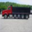

In [50]:
visualize(target_images[9][0].cpu().detach().clamp(0,1), reshape=False)

In [39]:
target_images[0].shape

torch.Size([1, 32, 32, 3])

In [34]:
target_img_indices = []
target_images = []
for i in range(10):
    while True:
        ind = np.random.randint(len(dataset_per_class[i]))
        source_image = common.torch.as_variable(dataset_per_class[i][[ind]], True)
        source_image = source_image.permute(0, 3, 1, 2).to(device)
        normal_pred = normal_model.model((source_image).clamp(0,1)).argmax(-1)[0]
        at_pred = at_model.model((source_image).clamp(0,1)).argmax(-1)[0]
        msd_pred = msd_model.model((source_image).clamp(0,1)).argmax(-1)[0]
        ccat_pred = ccat_model.model((source_image).clamp(0,1)).argmax(-1)[0]
        #print(ind)#, ind, normal_pred, at_pred, msd_pred, ccat_pred)
        if normal_pred == at_pred == msd_pred == ccat_pred == i:
            print(ind)
            target_img_indices.append(ind)
            target_images.append(dataset_per_class[i][[ind]])
            break

474
385
884
133
381
408
641
613
384
240


In [11]:
dataset_per_class[i][[ind]].shape

torch.Size([1, 1, 32, 32, 3])

In [6]:
def progress(batch, batches, epoch=None):
    """
    Report progress.

    :param epoch: epoch
    :type epoch: int
    :param batch: batch
    :type batch: int
    :param batches: batches
    :type batches: int
    """

    if batch == 0:
        if epoch is not None:
            log(' %d .' % epoch, end='')
        else:
            log(' .', end='')
    else:
        log('.', end='', context=False)

    if batch == batches - 1:
        log(' done', end="\n", context=False)

def test(model, testset, cuda=False, return_labels=False, normal=False):
    """
    Test a model on a clean or adversarial dataset.

    :param model: model
    :type model: torch.nn.Module
    :param testset: test set
    :type testset: torch.utils.data.DataLoader
    :param cuda: use CUDA
    :type cuda: bool
    :param return_labels: whether to additionally return labels
    :type return_labels: bool
    """

    assert model.training is False
    assert len(testset) > 0
    assert isinstance(testset, torch.utils.data.DataLoader)
    assert isinstance(testset.sampler, torch.utils.data.SequentialSampler)
    assert (cuda and common.torch.is_cuda(model)) or (not cuda and not common.torch.is_cuda(model))

    probabilities = None
    labels = None

    # should work with and without labels
    for b, data in enumerate(testset):
        if isinstance(data, tuple) or isinstance(data, list):
            inputs = data[0]
        else:
            inputs = data
        
        if return_labels is True:
            assert len(data) >= 2
            labels = common.numpy.concatenate(labels, data[1].numpy())
        
#         print(data[0].shape, data[1])
        assert isinstance(inputs, torch.Tensor)

        inputs = common.torch.as_variable(inputs, cuda)
        inputs = inputs.permute(0, 3, 1, 2)

        #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        logits = model(inputs)
        probabilities_ = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()
        probabilities = common.numpy.concatenate(probabilities, probabilities_)

        progress(b, len(testset))

    assert probabilities.shape[0] == len(testset.dataset)

    if return_labels:
        return probabilities, labels
    else:
        return probabilities

In [7]:
probabilities, labels = test(model, test_dataset, cuda=True, return_labels=True)

[011221203617|55.5747/57.7607MiB]  ................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.................................................................................................................................................................... done


In [67]:
model(list(test_dataset)[0][0].permute(0, 3, 1, 2).cuda()).shape

torch.Size([64, 10])

In [13]:
(pred == labels).astype(float).mean()

0.8992

array([3, 8, 8, ..., 5, 1, 7])

In [9]:
pred= np.argmax(probabilities, axis=-1)

In [75]:
score_dict = dict([(i, 0) for i in range(10)])
for p, g in zip(pred, labels):
    if p == g:
        score_dict[g] += 1

In [76]:
sum(score_dict.values())/100

91.73

In [82]:
#!/usr/bin/env python
import pickle
import torch
import common.state
import common.datasets
from common.log import log
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import prod    
import lpips
import time
import random
random.seed(2)
import argparse
import resnet
import torchvision.transforms as transforms

def progress(batch, batches, epoch=None):
    if batch == 0:
        if epoch is not None:
            log(' %d .' % epoch, end='')
        else:
            log(' .', end='')
    else:
        log('.', end='', context=False)

    if batch == batches - 1:
        log(' done', end="\n", context=False)

def visualize(inp, reshape=False):
    if reshape:
        inp = torch.stack((inp[0], inp[1], inp[2] ), dim=-1)
    return Image.fromarray((255*inp.numpy()).astype(np.uint8))

def batch_nullspace_attack(dataset, source_classes, model, stepsize, target_image, iterations, device, order=1, inp=None):
    # target_image = torch.ones(inp.shape, device=device).reshape((-1))
    source_image = common.torch.as_variable(dataset, True)
    source_image = source_image.permute(0, 3, 1, 2)
    source_classes = source_classes.to(device)
    if inp is None:
        inp = source_image.clone().to(device)
        inp.requires_grad_()
    target_image = common.torch.as_variable(target_image, True)
    target_image = target_image.permute(2, 0, 1)
    indices = torch.arange(len(inp))
    pred = model((inp).clamp(0,1))
    init_probs = softmax(pred)
    init_labels = torch.argmax(init_probs, dim=-1)
    irrel_images = init_labels != source_classes
#     step_size_vec = step_size*torch.ones(inp.shape)
    for i in range(iterations):
        pred = model((inp).clamp(0,1))
        probs = softmax(pred)
#        scaling_factors = 1 + 100*torch.sum((probs - init_probs)**2, dim=-1)
#        print(scaling_factors.mean())
        sum_probs = torch.sum(probs[indices,source_classes])
        sum_probs.backward()
        J = inp.grad.reshape(len(probs), prod(inp.shape[1:]))
        v = target_image.flatten() - inp.flatten(start_dim=1)
        null_vec = get_nullspace_projection(J, v).reshape(inp.shape)
#        new_inp = inp + (stepsize/scaling_factors).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)*null_vec
        new_inp = inp + stepsize*null_vec
        pred_probs = softmax(model(new_inp.clamp(0,1)))
        pred_labels = torch.argmax(pred_probs, dim=-1)
        mask = (pred_labels == init_labels).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        if ~ (mask.any()):
            print("Iterations stopped at:", i)
            break
        inp = (inp*(~mask) + new_inp*mask).detach()
        inp.requires_grad_()
    pred = model((inp).clamp(0,1))
    probs = softmax(pred)
    final_labels = torch.argmax(probs, dim=-1)
#     print(inp.expand(-1,3,-1,-1).shape, target_image.expand(3,-1,-1).shape)
    lpips_dist_target = lpips_dist(2*inp.expand(-1,3,-1,-1)-1 , 2*target_image.expand(3,-1,-1)-1)
    lpips_dist_target[irrel_images] = -1
    lpips_dist_source = lpips_dist(2*source_image.expand(-1,3,-1,-1)-1 , 2*inp.expand(-1,3,-1,-1)-1)
    lpips_dist_source[irrel_images] = -1
    assert torch.abs(final_labels - init_labels).max() == 0
    return inp, torch.cat((lpips_dist_target, lpips_dist_source), dim=-1)

def get_nullspace_projection(J, v):
    y_hat = torch.sum(J*v, -1, keepdim=True)/torch.sum(J * J, -1,  keepdim=True)
    x = v - (J * y_hat)
    return x


args_dist = 'lpips_alex'
if args_dist == 'lpips_alex':
    lpips_dist_func = lpips.LPIPS(net='alex') # best forward scores
else:
    lpips_dist_func = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args_dataset = 'cifar10'
args_model = 'normal'
model_name = args_dataset+"_"+args_model
if args_model == 'normal' and args_dataset == 'cifar10':
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    model = torch.nn.DataParallel(resnet.__dict__['resnet20']())
    model.to(device)
    model.load_state_dict(torch.load('../pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th')['state_dict'])
    model = torch.nn.Sequential(normalize, model)
else:
    model =  common.state.State.load('examples/readme/'+model_name+'/classifier.pth.tar').model
    model.to(device)

lpips_dist_func.to(device)
softmax = torch.nn.Softmax(dim=-1)
for p in model.parameters():
    p.requires_grad = False
model.eval()


def lpips_dist(a, b):
    if a.shape[-1] < 32:
        pad_len = (32 - a.shape[-1])//2 + 1	
    else:
        pad_len = 0
    a = torch.nn.functional.pad(a, (pad_len, pad_len, pad_len, pad_len), value=-1)
    b = torch.nn.functional.pad(b, (pad_len, pad_len, pad_len, pad_len), value=-1)
    return lpips_dist_func(a, b)

# train_dataset = torch.utils.data.DataLoader(common.datasets.Cifar10TrainSet(), batch_size=batch_size, shuffle=False, num_workers=0)
if args_dataset == 'cifar10':
    raw_test_dataset = common.datasets.Cifar10TestSet()
    test_dataset = torch.utils.data.DataLoader(common.datasets.Cifar10TestSet(), batch_size=64, shuffle=False, num_workers=0)
    classes = ['airplane',
                'automobile',
                'bird',
                'cat',
                'deer',
                'dog',
                'frog',
                'horse',
                'ship',
                'truck']
elif args_dataset == 'mnist':
    raw_test_dataset = common.datasets.MNISTTestSet()
    test_dataset = torch.utils.data.DataLoader(common.datasets.MNISTTestSet(), batch_size=args.batch_size, shuffle=False, num_workers=0)
    classes = [str(i) for i in range(10)]
    
data_dict = dict([(i, list()) for i in range(len(classes))])
try:
    for img, label in raw_test_dataset:
        data_dict[int(label)].append(torch.Tensor(img))
except AssertionError:
    pass

dataset_per_class = [torch.stack(data_dict[i]) for i in range(len(classes))]

target_img_indices = []
target_images = []

for i in range(len(classes)):
    while True:
        ind = random.randint(0, len(dataset_per_class[i]))
        if i == 3:
            ind = 261
        if i == 5:
            ind =6
        source_image = common.torch.as_variable(dataset_per_class[i][[ind]], False)
        source_image = source_image.permute(0, 3, 1, 2).to(device)
        pred = model((source_image).clamp(0,1))
        probs = torch.nn.functional.softmax(pred)
        pred_label = torch.argmax(probs, dim=-1)[0]
        print(i, ind, pred_label)
        if pred_label == i:
            target_img_indices.append(ind)
            target_images.append(dataset_per_class[i][ind])
            break


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /fs/classhomes/fall2021/cmsc828w/cs828w04/anaconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
[201021203256|100.447/102.733MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_images.h5
[201021203256|100.447/102.733MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_labels.h5
[201021203257|100.447/102.733MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_images.h5
[201021203257|100.447/102.733MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_labels.h5
0 978 tensor(0, device='cuda:0')
1 883 tensor(1, device='cuda:0')
2 970 tensor(2, device='cuda:0')
3 261 tensor(3, device='cuda:0')
4 57 tensor(4, device='cuda:0')
5 6 tensor(5, device='cuda:0')
6 86 tensor(6, de

<ipython-input-82-d6fc4950ee91>:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(pred)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /fs/classhomes/fall2021/cmsc828w/cs828w04/anaconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
[301021193749|342.676/491.551MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_images.h5
[301021193749|342.676/491.551MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_labels.h5
[301021193751|342.676/491.551MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_images.h5
[301021193751|342.676/491.551MiB] read /fs/classhomes/fall2021/cmsc828w/cs828w04/confidence-calibrated-adversarial-training/Cifar10/test_labels.h5


<ipython-input-18-6812cd3fb890>:191: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(pred)


0 864 tensor(0, device='cuda:0')
1 394 tensor(1, device='cuda:0')
2 776 tensor(2, device='cuda:0')
3 261 tensor(3, device='cuda:0')
4 430 tensor(4, device='cuda:0')
5 17 tensor(5, device='cuda:0')
6 265 tensor(6, device='cuda:0')
7 988 tensor(7, device='cuda:0')
8 523 tensor(8, device='cuda:0')
9 497 tensor(9, device='cuda:0')
[301021193755|344.539/491.551MiB]  0 . done
[301021193758|344.539/491.551MiB]  1 . done
[301021193801|344.539/491.551MiB]  2 . done
[301021193805|344.539/491.551MiB]  3 . done
[301021193808|344.539/491.551MiB]  4 . done
[301021193811|344.539/491.551MiB]  5 . done
[301021193815|344.539/491.551MiB]  6 . done
[301021193818|344.539/491.551MiB]  7 . done
[301021193822|344.539/491.551MiB]  8 . done
[301021193825|344.539/491.551MiB]  9 . done


<Figure size 432x288 with 0 Axes>

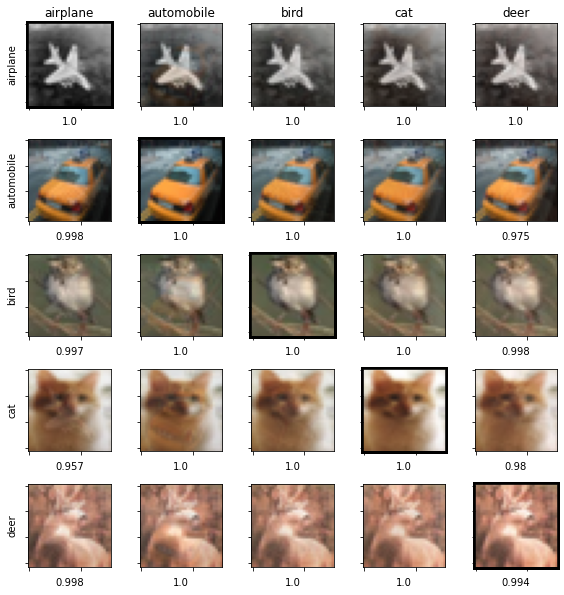

In [18]:
#!/usr/bin/env python
import pickle
import torch
import common.state
import common.datasets
from common.log import log
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import prod    
import lpips
import time
import random
random.seed(0)
import argparse
import resnet
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

plt.tight_layout()

def progress(batch, batches, epoch=None):
    if batch == 0:
        if epoch is not None:
            log(' %d .' % epoch, end='')
        else:
            log(' .', end='')
    else:
        log('.', end='', context=False)

    if batch == batches - 1:
        log(' done', end="\n", context=False)

def visualize(inp, reshape=False):
    if reshape:
        inp = torch.stack((inp[0], inp[1], inp[2] ), dim=-1)
    return Image.fromarray((255*inp.numpy()).astype(np.uint8))

def batch_nullspace_attack(dataset, source_classes, model, stepsize, target_image, iterations, device, order=1, inp=None):
    # target_image = torch.ones(inp.shape, device=device).reshape((-1))
    source_image = common.torch.as_variable(dataset, True)
    source_image = source_image.permute(0, 3, 1, 2)
    source_classes = source_classes.to(device)
    if inp is None:
        inp = source_image.clone().to(device)
        inp.requires_grad_()
    target_image = common.torch.as_variable(target_image, True)
    target_image = target_image.permute(2, 0, 1)
    indices = torch.arange(len(inp))
    pred = model((inp).clamp(0,1))
    init_probs = softmax(pred)
    init_labels = torch.argmax(init_probs, dim=-1)
    irrel_images = init_labels != source_classes
#     step_size_vec = step_size*torch.ones(inp.shape)
    for i in range(iterations):
        pred = model((inp).clamp(0,1))
        probs = softmax(pred)
#        scaling_factors = 1 + 100*torch.sum((probs - init_probs)**2, dim=-1)
#        print(scaling_factors.mean())
        sum_probs = torch.sum(probs[indices,source_classes])
        sum_probs.backward()
        J = inp.grad.reshape(len(probs), prod(inp.shape[1:]))
        v = target_image.flatten() - inp.flatten(start_dim=1)
        null_vec = get_nullspace_projection(J, v).reshape(inp.shape)
#        new_inp = inp + (stepsize/scaling_factors).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)*null_vec
        new_inp = inp + stepsize*null_vec
        pred_probs = softmax(model(new_inp.clamp(0,1)))
        pred_labels = torch.argmax(pred_probs, dim=-1)
        #mask = (pred_labels == init_labels).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        mask = (pred_probs[torch.arange(len(pred_probs)),init_labels] > init_probs[torch.arange(len(pred_probs)),init_labels] - 0.1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
#         print(pred_probs.shape)
#         print(mask.shape)
        if ~ (mask.any()):
            print("Iterations stopped at:", i)
            break
        inp = (inp*(~mask) + new_inp*mask).detach()
        inp.requires_grad_()
    pred = model((inp).clamp(0,1))
    probs = softmax(pred)
    final_labels = torch.argmax(probs, dim=-1)
#     print(inp.expand(-1,3,-1,-1).shape, target_image.expand(3,-1,-1).shape)
    lpips_dist_target = lpips_dist(2*inp.expand(-1,3,-1,-1)-1 , 2*target_image.expand(3,-1,-1)-1)
    lpips_dist_target[irrel_images] = -1
    lpips_dist_source = lpips_dist(2*source_image.expand(-1,3,-1,-1)-1 , 2*inp.expand(-1,3,-1,-1)-1)
    lpips_dist_source[irrel_images] = -1
    assert torch.abs(final_labels - init_labels).max() == 0
    return inp, torch.cat((lpips_dist_target, lpips_dist_source), dim=-1)

def get_nullspace_projection(J, v):
    y_hat = torch.sum(J*v, -1, keepdim=True)/torch.sum(J * J, -1,  keepdim=True)
    x = v - (J * y_hat)
    return v*(y_hat > 0) + (x)*(y_hat < 0)

args_dist = 'lpips_alex'
if args_dist == 'lpips_alex':
    lpips_dist_func = lpips.LPIPS(net='alex') # best forward scores
else:
    lpips_dist_func = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args_dataset = 'cifar10'
args_model = 'normal'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = args_dataset+"_"+args_model
if args_model == 'normal' and args_dataset == 'cifar10':
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    model = resnet.__dict__['resnet20']()
    model.to(device)
    state_dict = torch.load('../pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th')['state_dict']
    new_state_dict = dict([])
    for k, v in state_dict.items():
        new_state_dict[k[7:]] = v
    model.load_state_dict(new_state_dict)
    #model.load_state_dict(torch.load('../pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th')['state_dict'])
    model = torch.nn.Sequential(normalize, model)
else:
    model =  common.state.State.load('examples/readme/'+model_name+'/classifier.pth.tar').model
    model.to(device)

args_batch_size = 10
if args_model == 'normal':
    target_layer = model[-1].layer3[-1]
elif args_model == 'at':
    target_layer = model.block2[-1]
elif args_model == 'msd':
    target_layer = model.layer4[-1]
    
cam = EigenCAM(model=model, target_layer=target_layer, use_cuda=True)

lpips_dist_func.to(device)
softmax = torch.nn.Softmax(dim=-1)
for p in model.parameters():
    p.requires_grad = False
model.eval()


def lpips_dist(a, b):
    if a.shape[-1] < 32:
        pad_len = (32 - a.shape[-1])//2 + 1	
    else:
        pad_len = 0
    a = torch.nn.functional.pad(a, (pad_len, pad_len, pad_len, pad_len), value=-1)
    b = torch.nn.functional.pad(b, (pad_len, pad_len, pad_len, pad_len), value=-1)
    return lpips_dist_func(a, b)

args_iters = 200
args_step_size = 1e-2
if args_dataset == 'cifar10':
    raw_test_dataset = common.datasets.Cifar10TestSet()
    test_dataset = torch.utils.data.DataLoader(common.datasets.Cifar10TestSet(), batch_size=args_batch_size, shuffle=False, num_workers=0)
    classes = ['airplane',
                'automobile',
                'bird',
                'cat',
                'deer',
                'dog',
                'frog',
                'horse',
                'ship',
                'truck']
elif args_dataset == 'mnist':
    raw_test_dataset = common.datasets.MNISTTestSet()
    test_dataset = torch.utils.data.DataLoader(common.datasets.MNISTTestSet(), batch_size=args_batch_size, shuffle=False, num_workers=0)
    classes = [str(i) for i in range(10)]
    
data_dict = dict([(i, list()) for i in range(len(classes))])
try:
    for img, label in raw_test_dataset:
        data_dict[int(label)].append(torch.Tensor(img))
except AssertionError:
    pass

dataset_per_class = [torch.stack(data_dict[i]) for i in range(len(classes))]

target_img_indices = []
target_images = []

for i in range(len(classes)):
    while True:
        ind = random.randint(0, len(dataset_per_class[i]))
        if i == 3:
            ind = 261
        if i == 5:
            ind = 17
        source_image = common.torch.as_variable(dataset_per_class[i][[ind]], False)
        source_image = source_image.permute(0, 3, 1, 2).to(device)
        pred = model((source_image).clamp(0,1))
        probs = torch.nn.functional.softmax(pred)
        pred_label = torch.argmax(probs, dim=-1)[0]
        print(i, ind, pred_label)
        if pred_label == i:
            target_img_indices.append(ind)
            target_images.append(dataset_per_class[i][ind])
            break


def run_attack(dataset , target_images):
    inp_per_class = []
    dist_per_class = []
    for i, image in enumerate(target_images):
        all_inp = []
        all_dist = []
        for b, data_batch in enumerate(dataset):
            inp, dist = batch_nullspace_attack(data_batch[0], data_batch[1], model, args_step_size, image, args_iters, device)
            all_inp.append(inp.cpu().detach())
            all_dist.append(dist.cpu().detach())
            progress(b, len(dataset) , epoch=i)
        all_inp = torch.cat(all_inp, dim=0)
        all_dist = torch.cat(all_dist, dim=0)
        inp_per_class.append(all_inp)
        dist_per_class.append(all_dist)
    inp_per_class = torch.stack(inp_per_class, dim=0).cpu().detach().numpy()
    dist_per_class = torch.stack(dist_per_class, dim=0).cpu().detach().numpy()
    return inp_per_class, dist_per_class

inp_per_class, dist_per_class = run_attack([(torch.stack(target_images, dim=0),  torch.arange(len(classes)))], target_images) 
classes = classes[:5]
f, axarr = plt.subplots(len(classes),len(classes), figsize=(2*len(classes),2*len(classes))) 
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.4)

for i in range(len(classes)):
    for j in range(len(classes)):
        if j == 0:
            axarr[i, j].set_ylabel(classes[i])
        if i == 0:
            axarr[i, j].set_title(classes[j])
        inp_per_class[i, j] = inp_per_class[i, j].clip(0,1)
        input_tensor = torch.Tensor(inp_per_class[i, j]).unsqueeze(0)
        input_tensor.requires_grad_()
        grayscale_cam = cam(input_tensor=input_tensor, target_category=j)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(inp_per_class[i, j].transpose((1, 2, 0)), grayscale_cam, use_rgb=True)

        axarr[i, j].imshow(inp_per_class[i, j].transpose((1, 2, 0))) 
#         axarr[i, j].imshow(visualization) 
        axarr[i, j].set_yticklabels([])
        axarr[i, j].set_xticklabels([])
        #axarr[i, j].set_xlabel(np.round(dist_per_class[i, j].squeeze(), 3))
        with torch.no_grad():
            axarr[i, j].set_xlabel(np.round(softmax(model(input_tensor.to(device)))[0][j].cpu().numpy() , 3))
        if i == j:
            axarr[i, j].patch.set_edgecolor('black')  
            axarr[i, j].patch.set_linewidth('5')  
plt.show()
#plt.savefig('./'+model_name+'_examples.png')


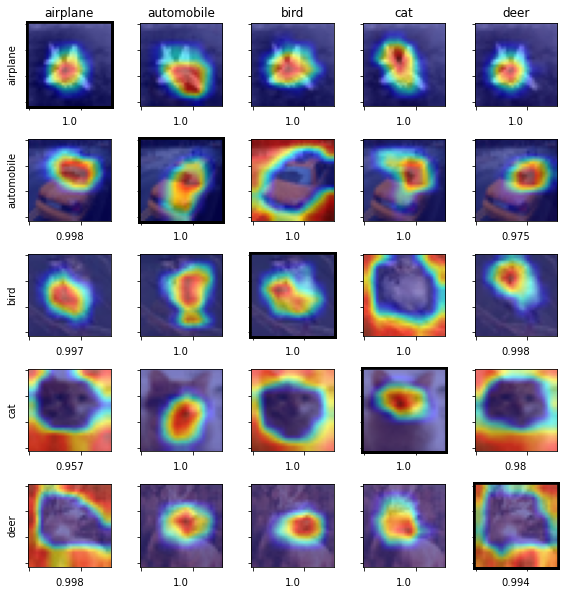

In [20]:
f, axarr = plt.subplots(len(classes),len(classes), figsize=(2*len(classes),2*len(classes))) 
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.4)

for i in range(len(classes)):
    for j in range(len(classes)):
        if j == 0:
            axarr[i, j].set_ylabel(classes[i])
        if i == 0:
            axarr[i, j].set_title(classes[j])
        inp_per_class[i, j] = inp_per_class[i, j].clip(0,1)
        input_tensor = torch.Tensor(inp_per_class[i, j]).unsqueeze(0)
        input_tensor.requires_grad_()
        grayscale_cam = cam(input_tensor=input_tensor, target_category=j)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(inp_per_class[i, j].transpose((1, 2, 0)), grayscale_cam, use_rgb=True)

#             axarr[i, j].imshow(inp_per_class[i, j].transpose((1, 2, 0))) 
        axarr[i, j].imshow(visualization) 
        axarr[i, j].set_yticklabels([])
        axarr[i, j].set_xticklabels([])
        #axarr[i, j].set_xlabel(np.round(dist_per_class[i, j].squeeze(), 3))
        with torch.no_grad():
            axarr[i, j].set_xlabel(np.round(softmax(model(input_tensor.to(device)))[0][j].cpu().numpy() , 3))
        if i == j:
            axarr[i, j].patch.set_edgecolor('black')  
            axarr[i, j].patch.set_linewidth('5')  
plt.show()

In [11]:
a = torch.Tensor([[1,2],[3,4],[5,6]])

In [14]:
a[[0,1,2],[1,0,1]]

tensor([2., 3., 6.])